Adni ordering with sustain.

In [1]:
import pandas as pd 
import numpy as np 
import os 
from pySuStaIn.MixtureSustain import MixtureSustain
from kde_ebm.mixture_model import fit_all_gmm_models, fit_all_kde_models
import time
from typing import List, Optional
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle
import shutil

/home/hhao9/miniconda/envs/jobs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def save_debm_heatmap(
    bootstrap_orderings: List,  # List of orderings from bootstrap iterations
    biomarker_names: List[str],
    folder_name: str,
    file_name: str,
    title: str,
    mean_ordering: Optional[List[int]] = None,
    plot_mean_order: bool = True  # Whether to sort by mean ordering
):
    """
    Create a heatmap showing the positional variance of biomarkers across bootstrap iterations.
    Similar to what's shown in Archetti 2019 and the pyebm documentation.
    
    Args:
        bootstrap_orderings: List of orderings from each bootstrap iteration
        biomarker_names: List of biomarker names
        folder_name: Directory to save the plot
        file_name: Name of the output file
        title: Title for the plot
        mean_ordering: Mean ordering across all bootstraps (if not provided, will be calculated)
        plot_mean_order: If True, sort biomarkers by their mean position
    """
    os.makedirs(folder_name, exist_ok=True)
    
    n_biomarkers = len(biomarker_names)
    n_bootstraps = len(bootstrap_orderings)
    
    # Create a matrix to count occurrences of each biomarker at each position
    position_counts = np.zeros((n_biomarkers, n_biomarkers))
    
    # Count how many times each biomarker appears at each position
    for ordering in bootstrap_orderings:
        for position, biomarker_idx in enumerate(ordering):
            position_counts[biomarker_idx, position] += 1
    
    # Convert to DataFrame
    biomarker_position_df = pd.DataFrame(
        position_counts,
        index=biomarker_names,
        columns=range(1, n_biomarkers + 1)  # Stage positions 1 to N
    )
    
    # If mean ordering is provided or we want to plot by mean order
    if plot_mean_order:
        
        # Reorder biomarkers by mean ordering
        ordered_biomarker_names = [biomarker_names[i] for i in mean_ordering]
        biomarker_position_df = biomarker_position_df.loc[ordered_biomarker_names]
        
        # Add ordering numbers to biomarker names
        renamed_index = [f"{name} ({i+1})" for i, name in enumerate(ordered_biomarker_names)]
        biomarker_position_df.index = renamed_index
    
    # Normalize to show proportions/probabilities
    biomarker_position_df = biomarker_position_df.div(n_bootstraps)
    
    # Find the longest biomarker name
    max_name_length = max(len(name) for name in biomarker_position_df.index)
    
    # Dynamically adjust figure size
    fig_width = max(10, min(20, n_biomarkers * 0.5))  # Scale with number of biomarkers
    fig_height = max(8, min(15, n_biomarkers * 0.4))
    
    plt.figure(figsize=(fig_width, fig_height))
    
    # Create heatmap
    sns.heatmap(
        biomarker_position_df,
        annot=True,
        cmap="Blues",  # Use Blues to match pyebm visualization
        linewidths=0.5,
        cbar_kws={'label': 'Probability'},
        fmt=".2f",
        vmin=0,
        vmax=1
    )
    
    plt.xlabel('Stage Position')
    plt.ylabel('Biomarker')
    plt.title(title)
    
    # Adjust y-axis ticks
    plt.yticks(rotation=0, ha='right')
    
    # Adjust margins
    plt.subplots_adjust(left=0.3 if max_name_length > 20 else 0.2)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"{folder_name}/{file_name}.pdf", bbox_inches="tight", dpi=300)
    plt.savefig(f"{folder_name}/{file_name}.png", bbox_inches="tight", dpi=300)
    plt.close()
    
    return biomarker_position_df

In [3]:
RESULTS_DIR = 'sustain_ordering_gmm'
os.makedirs(RESULTS_DIR, exist_ok=True)
data_file = '../adni.csv'

sustainType = 'mixture_KDE'

start_time = time.time()
# read file
df = pd.read_csv(data_file)
df.drop(columns=['participant'], inplace=True)

# extract data 
biomarker_labels = list(df.columns)[:-1]
data_matrix = df.to_numpy()
data = data_matrix[:, :-1].astype(np.float64)
target = data_matrix[:, -1].astype(np.int64)
diseased_mask = (target == 1) # ad

# prepare for sustain analysis 
if sustainType == "mixture_GMM":
    mixtures = fit_all_gmm_models(data, target)
elif sustainType == "mixture_KDE":
    mixtures = fit_all_kde_models(data, target)

# Extract likelihoods for each biomarker
L_yes = np.zeros(data.shape)
L_no = np.zeros(data.shape)
for i in range(data.shape[1]):
    if sustainType == "mixture_GMM":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(None, data[:, i])
    elif sustainType == "mixture_KDE":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(data[:, i].reshape(-1, 1))

LinAlgError: Singular matrix

In [32]:
# -------------------------------------------------------------------------
# Full MCMC run (20k mcmc iterations)
# -------------------------------------------------------------------------
# parameter setting 
N_startpoints = 25  # Number of starting points for optimization
N_S_max = 6  # Maximum number of subtypes (From sustain-adni-cv.ipynb)
N_iterations_MCMC = 10_0000  # Number of MCMC iterations
dataset_name = 'adni'
use_parallel_startpoints = True

# from collections import defaultdict
# dic = defaultdict(float)

# for _ in range(10):
#     x = np.random.randint(1, 2**32 - 1)

#     sustain_model = MixtureSustain(
#         L_yes, 
#         L_no, 
#         biomarker_labels,  # biomarker labels
#         N_startpoints, 
#         N_S_max, 
#         N_iterations_MCMC, 
#         'sustain_ordering_gmm', 
#         dataset_name, 
#         use_parallel_startpoints,
#         seed=x,
#     )

#     samples_sequence, samples_f, ml_subtype, _, ml_stage, _, _ = sustain_model.run_sustain_algorithm(plot=False)

#     pickle_filename = os.path.join(sustain_model.output_folder, 'pickle_files', 
#                                 f'{sustain_model.dataset_name}_subtype{sustain_model.N_S_max-1}.pickle')

#     with open(pickle_filename, 'rb') as f:
#         loaded_variables = pickle.load(f)

#     samples_likelihood = np.asarray(loaded_variables["samples_likelihood"]).reshape(-1)
#     max_ll = samples_likelihood.max()
#     dic[x] = max_ll
#     print("Max likelihood from EM:", max_ll)

#     # --- delete pickle_files folder after use ---
#     pickle_dir = os.path.join(sustain_model.output_folder, "pickle_files")
#     if os.path.exists(pickle_dir):
#         shutil.rmtree(pickle_dir)

In [33]:
# dic 

```py
defaultdict(float,
            {16821364: np.float64(-5045.432559480009),
             3777769934: np.float64(-5040.252828471661),
             781668625: np.float64(-5039.884432947263), # Highest data likelihood
             3623566792: np.float64(-5040.253003682067),
             2809423948: np.float64(-5039.893476483663),
             4172394747: np.float64(-5040.252645780216),
             3617117918: np.float64(-5040.253021989563),
             3105685757: np.float64(-5045.42959779423),
             1470247110: np.float64(-5040.253003682067),
             718146467: np.float64(-5048.787805534817)})
```

In [34]:
seed = 781668625

sustain_model = MixtureSustain(
        L_yes, 
        L_no, 
        biomarker_labels,  # biomarker labels
        N_startpoints, 
        N_S_max, 
        N_iterations_MCMC, 
        'sustain_ordering_gmm', 
        dataset_name, 
        use_parallel_startpoints,
        seed=seed,
    )

samples_sequence, samples_f, ml_subtype, _, ml_stage, _, _ = sustain_model.run_sustain_algorithm(plot=False)

Found pickle file: sustain_ordering_gmm/pickle_files/adni_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: sustain_ordering_gmm/pickle_files/adni_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: sustain_ordering_gmm/pickle_files/adni_subtype2.pickle. Using pickled variables for 2 subtype.
Found pickle file: sustain_ordering_gmm/pickle_files/adni_subtype3.pickle. Using pickled variables for 3 subtype.
Found pickle file: sustain_ordering_gmm/pickle_files/adni_subtype4.pickle. Using pickled variables for 4 subtype.
Found pickle file: sustain_ordering_gmm/pickle_files/adni_subtype5.pickle. Using pickled variables for 5 subtype.


<!-- ```py
defaultdict(float,
            {1550542337: np.float64(-5054.81435946555),
             3088029222: np.float64(-5054.813513818735),
             476528343: np.float64(-5054.814339996322),
             3878327782: np.float64(-5054.8143179449135),
             51679124: np.float64(-5054.812889747838),
             2888941611: np.float64(-5052.977962380528),
             1465262393: np.float64(-5054.813789710054),
             110709215: np.float64(-5057.688234168027),
             2863785221: np.float64(-5054.81390013252),
             2947453009: np.float64(-5055.264845675298)})
``` -->

In [35]:
samples_sequence.shape 

(6, 12, 100000)

In [36]:
samples_sequence[:,:,0].shape

(6, 12)

In [37]:
samples_sequence[:,:,0]

array([[ 3.,  5.,  4.,  0.,  2.,  7.,  9.,  1., 11., 10.,  8.,  6.],
       [ 3.,  6.,  7.,  9.,  0.,  2., 10., 11.,  8.,  1.,  5.,  4.],
       [ 0.,  2.,  1., 10.,  3.,  7.,  9.,  6., 11.,  8.,  5.,  4.],
       [10.,  7.,  9., 11.,  8.,  6.,  2.,  0.,  1.,  3.,  5.,  4.],
       [ 3.,  2.,  0.,  1.,  5.,  4.,  9.,  7., 11., 10.,  8.,  6.],
       [ 5.,  4.,  9.,  0.,  7.,  1.,  2.,  6.,  3., 11., 10.,  8.]])

In [38]:
np.argsort(samples_sequence[:,:,0])

array([[ 3,  7,  4,  0,  2,  1, 11,  5, 10,  6,  9,  8],
       [ 4,  9,  5,  0, 11, 10,  1,  2,  8,  3,  6,  7],
       [ 0,  2,  1,  4, 11, 10,  7,  5,  9,  6,  3,  8],
       [ 7,  8,  6,  9, 11, 10,  5,  1,  4,  2,  0,  3],
       [ 2,  3,  1,  0,  5,  4, 11,  7, 10,  6,  9,  8],
       [ 3,  5,  6,  8,  1,  0,  7,  4, 11,  2, 10,  9]])

In [39]:
samples_sequence[:,:,0].T.shape

(12, 6)

In [40]:
samples_sequence[0, :, :].T.astype(int)

array([[ 3,  5,  4, ..., 10,  8,  6],
       [ 3,  5,  4, ..., 10,  8,  6],
       [ 3,  5,  4, ..., 10,  8,  6],
       ...,
       [ 3,  5,  4, ..., 10,  6,  8],
       [ 3,  5,  4, ..., 10,  6,  8],
       [ 3,  5,  4, ..., 10,  6,  8]])

In [41]:
res = samples_sequence[0, :, :].T.astype(int)
np.array(biomarker_labels)[res[0]]

array(['ABETA', 'PTAU', 'TAU', 'ADAS13', 'RAVLT_immediate',
       'HippocampusNorm', 'EntorhinalNorm', 'MMSE', 'MidTempNorm',
       'FusiformNorm', 'WholeBrainNorm', 'VentricleNorm'], dtype='<U15')

In [42]:
N_S_max

6

In [43]:
for t in range(N_S_max):
    # all sequences of this subtype
    res = samples_sequence[t, :, :].T.astype(int)
    save_debm_heatmap(
            bootstrap_orderings=np.argsort(res),
            biomarker_names=np.array(biomarker_labels)[res[0]],
            folder_name='sustain_ordering_gmm',
            file_name=f"sustain_adni_subtype{t+1}",
            title=f"ADNI Ordering Result of Subtype {t+1} with SuStaIn",
            mean_ordering=samples_sequence[t,:,0].astype(int),
            plot_mean_order=True
        )

In [44]:
healthy_mask = (target == 0)

In [45]:
# EM-only: force the assignment to use just the EM sample (index 0)
ml_subtype_em, p_ml_subtype_em, ml_stage_em, p_ml_stage_em, *_ = \
    sustain_model.subtype_and_stage_individuals_newData(
        L_yes, L_no, samples_sequence, samples_f, N_samples=1
)
best_order_matrix = samples_sequence[:, :, 0]
ml_subtype_em = ml_subtype_em.flatten()
ml_stage_em = ml_stage_em.flatten()
ml_subtype = ml_subtype.flatten()
ml_stage = ml_stage.flatten()

In [46]:
mean_stage_healthy = np.mean(ml_stage[healthy_mask])
print(mean_stage_healthy)

2.47741935483871


In [47]:
mean_stage_healthy = np.mean(ml_stage_em[healthy_mask])
print(mean_stage_healthy)

2.6193548387096772


In [48]:
# count subtypes
from collections import Counter
counts = Counter(ml_subtype)
total = sum(counts.values())

# convert to DataFrame
df_counts = pd.DataFrame(
    [(k, v, v/total) for k, v in counts.items()],
    columns=["subtype", "count", "proportion"]
).sort_values(by=['subtype'])

print(df_counts)

   subtype  count  proportion
2      0.0    342    0.471074
1      1.0    124    0.170799
0      2.0    148    0.203857
4      3.0     54    0.074380
3      4.0     46    0.063361
5      5.0     12    0.016529


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def show_debm_heatmaps_grid(
    all_bootstrap_orderings,
    biomarker_names,
    subtype_names,
    subtype_ns,
    mean_orderings=None,
    plot_mean_order=True
):
    """
    Show a grid of SuStaIn-style positional variance heatmaps for multiple subtypes.
    Does not save to file, just displays with plt.show().
    """

    n_subtypes = len(all_bootstrap_orderings)
    n_biomarkers = len(biomarker_names)

    ncols = min(3, n_subtypes)
    nrows = int(np.ceil(n_subtypes / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(ncols * 5, nrows * 5),
        constrained_layout=True
    )

    if nrows == 1:
        axes = np.array([axes])

    for idx, bootstrap_orderings in enumerate(all_bootstrap_orderings):
        row, col = divmod(idx, ncols)
        ax = axes[row, col]

        # count positions
        position_counts = np.zeros((n_biomarkers, n_biomarkers))
        for ordering in bootstrap_orderings:
            for pos, biomarker_idx in enumerate(ordering):
                position_counts[biomarker_idx, pos] += 1

        df = pd.DataFrame(
            position_counts,
            index=biomarker_names,
            columns=range(1, n_biomarkers + 1)
        ).div(len(bootstrap_orderings))

        if plot_mean_order:
            mo = mean_orderings[idx] if mean_orderings is not None else np.argsort(position_counts.mean(axis=1))
            ordered_names = [biomarker_names[i] for i in mo]
            df = df.loc[ordered_names]

        sns.heatmap(
            df,
            cmap="Blues",
            cbar=(idx == n_subtypes - 1),
            vmin=0, vmax=1,
            xticklabels=True,
            yticklabels=True,
            ax=ax
        )

        # ax.set_yticklabels(ax.get_yticklabels(), fontsize=13, fontweight="bold")
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
        ax.set_title(f"{subtype_names[idx]}, n={subtype_ns[idx]}")
        ax.set_xlabel("SuStaIn Stage")
        if col == 0:
            ax.set_ylabel("Biomarker")
        else:
            ax.set_ylabel("")

    # Hide extra empty panels
    for j in range(n_subtypes, nrows * ncols):
        row, col = divmod(j, ncols)
        axes[row, col].axis("off")
    
    plt.savefig(f"sustain_ordering_gmm/all_ordering_sustain.pdf", bbox_inches="tight", dpi=300)
    plt.savefig(f"sustain_ordering_gmm/all_ordering.png", bbox_inches="tight", dpi=300)

    plt.show()
    plt.close()


In [50]:
all_bootstrap_orderings = []
mean_orderings = []
subtype_names = []
subtype_ns = []

for t in range(N_S_max):  # subtypes 0..5
    # Extract bootstrap orderings for subtype t
    res = samples_sequence[t, :, :].T.astype(int)   # shape (n_bootstraps, n_biomarkers)
    all_bootstrap_orderings.append([list(order) for order in res])

    # Mean ordering (you can replace with ML sequence if you prefer)
    mean_orderings.append(samples_sequence[t, :, 0].astype(int))

    # Names and counts
    subtype_names.append(f"Subtype {t + 1}")
    subtype_ns.append(np.sum(ml_subtype == t))  

In [51]:
plt.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.titlesize": 13
})

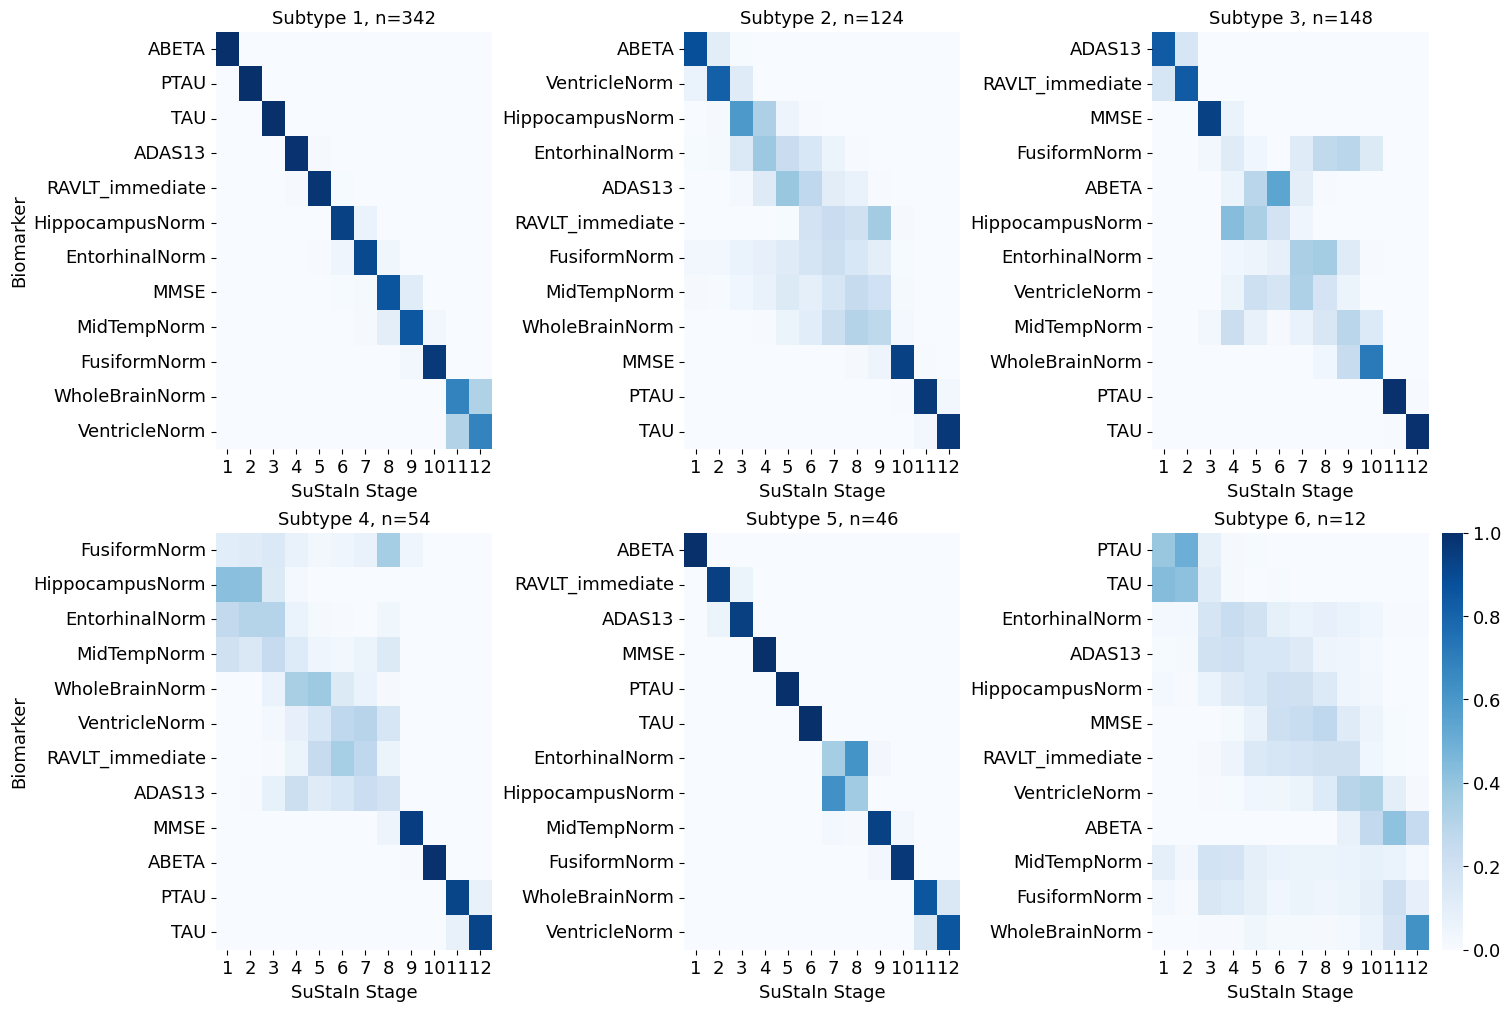

In [52]:
show_debm_heatmaps_grid(
    all_bootstrap_orderings=all_bootstrap_orderings,
    biomarker_names=biomarker_labels,
    subtype_names=subtype_names,
    subtype_ns=subtype_ns,
    mean_orderings=mean_orderings,
    plot_mean_order=True
)

In [53]:
ml_subtype = ml_subtype.flatten().astype(int)
dx_array = np.load("../dx_array.npy", allow_pickle=True)
ml_stage = ml_stage.flatten().astype(int)

In [54]:
df = pd.DataFrame({
    "Subtype": ml_subtype,
    "Stage": ml_stage,
    "DX": dx_array
})

In [55]:
# Make subtype 1-based
df["Subtype"] = df["Subtype"] + 1

# Fractions per subtype
composition = pd.crosstab(df["Subtype"], df["DX"], normalize="index").round(2)
print(composition)


DX         AD    CN  EMCI  LMCI
Subtype                        
1        0.31  0.16  0.21  0.32
2        0.03  0.30  0.32  0.35
3        0.27  0.14  0.25  0.34
4        0.00  0.35  0.28  0.37
5        0.02  0.39  0.28  0.30
6        0.17  0.42  0.33  0.08


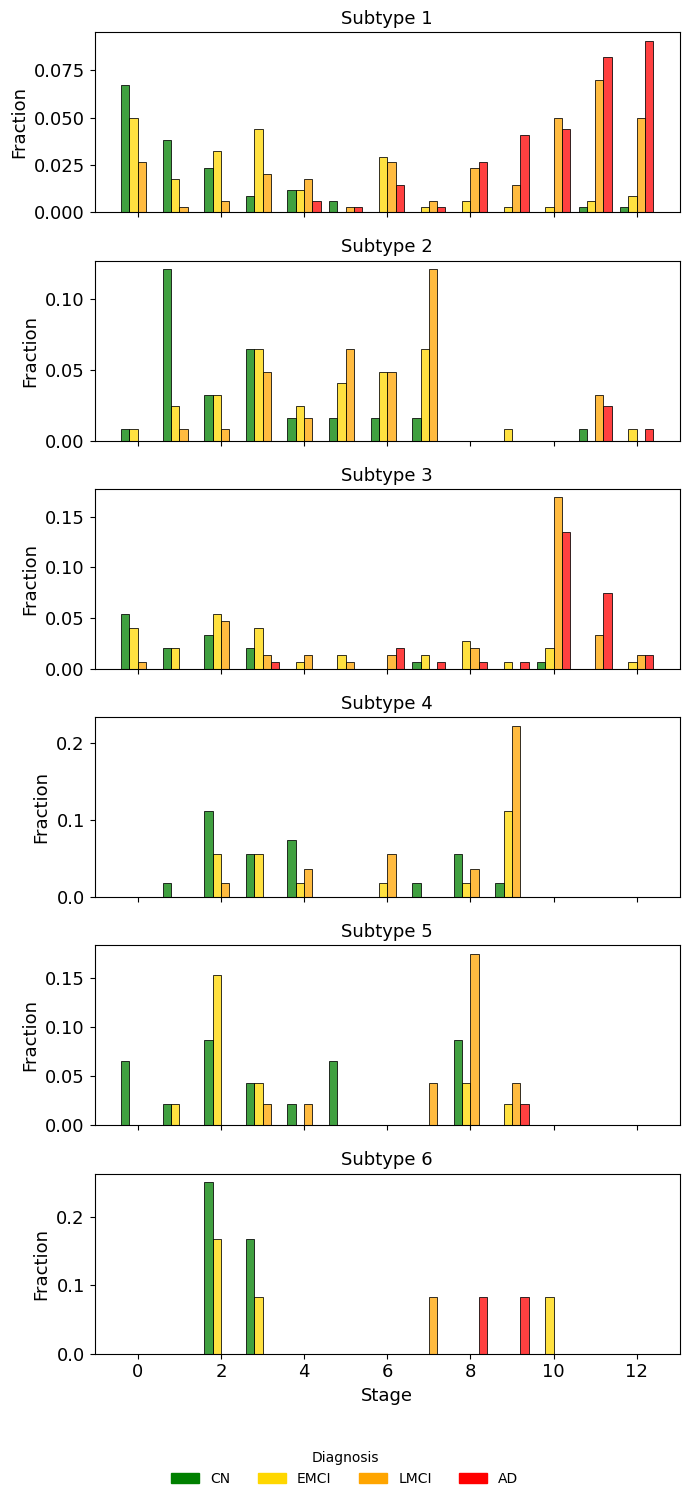

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Example DataFrame (replace with your actual arrays)
df = pd.DataFrame({
    "Subtype": ml_subtype,
    "Stage": ml_stage,
    "DX": dx_array
})

dx_order = ["CN", "EMCI", "LMCI", "AD"]
palette = {
    "CN": "green",
    "EMCI": "gold",
    "LMCI": "orange",
    "AD": "red"
}

n_subtypes = df["Subtype"].nunique()
fig, axes = plt.subplots(n_subtypes, 1, figsize=(7, 2.5*n_subtypes), sharex=True)

if n_subtypes == 1:
    axes = [axes]

for subtype, ax in zip(sorted(df["Subtype"].unique()), axes):
    sub_df = df[df["Subtype"] == subtype]

    sns.histplot(
        data=sub_df,
        x="Stage",
        hue="DX",
        hue_order=dx_order,
        stat="probability",
        multiple="dodge",
        discrete=True,
        shrink=0.8,
        palette=palette,
        ax=ax
    )
    
    ax.set_title(f"Subtype {subtype+1}", fontsize=13)
    ax.set_ylabel("Fraction", fontsize=13)
    ax.legend_.remove()

axes[-1].set_xlabel("Stage", fontsize=13)

# Build one clean legend manually
legend_handles = [Patch(color=palette[dx], label=dx) for dx in dx_order]
fig.legend(
    handles=legend_handles,
    title="Diagnosis",
    loc="lower center",
    ncol=4,
    frameon=False,
    fontsize=10
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(f"sustain_ordering_gmm/all_staging_sustain.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"sustain_ordering_gmm/all_staging.png", bbox_inches="tight", dpi=300)
